In [1]:
import sys
import os
import random
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.nn import Module

BATCH_SIZE = 128
NOISE_DIM = 100
X_MEAN = [0.5, 0.5, 0.5]
X_STD = [0.5, 0.5, 0.5]
C_DIM = 64
RANDOM_SEED = 19940808
EPOCH_TIME = 120
LEARNING_RATE = 2e-4
BETA1 = 1/2
BETA2 = 0.999

if torch.cuda.is_available():
  print( "Cuda is available")
  device = torch.device( 'cuda')
  dtype = torch.cuda.FloatTensor
else:
  device = torch.device('cpu')
  dtype = torch.FloatTensor

workspace_dir = '.'
workname = 'hw1'

Cuda is available


## 当在Google colab上执行时，运行本单元格

In [ ]:
from google.colab import drive

workspace_dir = os.path.join( '.' , 'drive', 'My Drive', 'Gan')
drive.mount( '/content/drive/' )
sys.path.append( workspace_dir)

! rm -rf data
! mkdir data
! tar zxf "{workspace_dir}/AnimeDataset/faces.tar.gz" -C data
! cp "{workspace_dir}/labels.csv" ./data
! ls -al data

In [3]:
from DataLoader import get_dataloader
%load_ext autoreload
%autoreload 2

In [4]:
# 手动设置随机种子
def same_seeds(seed = RANDOM_SEED):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Optimiter生成函数
def get_optimer( model, lr = LEARNING_RATE, beta1 = BETA1, beta2 = BETA2 ):
    return torch.optim.Adam( model.parameters() , lr, ( beta1, beta2))

In [5]:
same_seeds()

In [6]:
def weights_init( m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_( m.weight.data, 0.0, 0.02)
    elif classname.find( 'BatchNorm') != -1:
        nn.init.normal_( m.weight.data, 1.0, 0.02)
        nn.init.constant_( m.bias.data, 0)

class Generator(nn.Module):
    """
    input (N, in_dim)
    output (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU())
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4),
            dconv_bn_relu(dim * 4, dim * 2),
            dconv_bn_relu(dim * 2, dim),
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh())
        self.apply(weights_init)
    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2_5(y)
        return y

class Discriminator(nn.Module):
    """
    input (N, 3, 64, 64)
    output (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()
        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2))
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            nn.Conv2d(dim * 8, 1, 4),
            nn.Sigmoid())
        self.apply(weights_init)        
    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

## 训练逻辑和梯度下降过程

In [ ]:
if not os.path.exists( os.path.join( workspace_dir, workname) ):
  os.makedirs(path)

D = Discriminator( 3).to( device)
D_solver = get_optimer( D)

G = Generator( NOISE_DIM).to( device)
G_solver = get_optimer( G)

criterion = nn.BCELoss()
label_real = 1; label_fake = 0
train_loader = get_dataloader( 'data', BATCH_SIZE)
print("Starting Training Loop...")

# Used for warm training if interrupt unnormally
INDEX = 0
if INDEX > 4:
  G_pth = os.path.join( workspace_dir, workname, f"G_dcgan_{INDEX}.pth")
  D_pth = os.path.join( workspace_dir, workname, f"D_dcgan_{INDEX}.pth")
  G.load_state_dict( torch.load( G_pth))
  D.load_state_dict( torch.load( D_pth))

D.train(); G.train()
for epoch in range( INDEX, EPOCH_TIME):
    for i, ( X, y) in enumerate( train_loader):
      # 1. Train the discriminator
      if len(X) != BATCH_SIZE: continue
      D.zero_grad()
 
      y_fake = torch.full( ( BATCH_SIZE,), label_fake, device = device).detach()
      # noise = torch.randn( BATCH_SIZE, NOISE_DIM, 1, 1, device = device)
      noise = torch.randn( BATCH_SIZE, NOISE_DIM, device = device)
      fake_images = G( noise).detach()

      scores_fake = D( fake_images).view(-1)
      loss_D_fake = criterion( scores_fake, y_fake)

      y_real = torch.full( ( BATCH_SIZE, ), label_real, device = device).detach()
      scores_real = D( X.to(device) ).view(-1)
      loss_D_real = criterion( scores_real, y_real)

      loss_D = (loss_D_fake + loss_D_real) / 2
      loss_D.backward()
      D_solver.step()

      # 2. Train the generator
      G.zero_grad()


      # noise = torch.randn( BATCH_SIZE, NOISE_DIM, 1, 1, device = device)
      noise = torch.randn( BATCH_SIZE, NOISE_DIM, device = device)
      fake_images = G( noise)
      scores_fake = D( fake_images).view(-1)
      loss_G = criterion( scores_fake, y_real)

      loss_G.backward()
      G_solver.step()

      # 3. Print train process
      print( "\r [%d/%d][%d/%d]\tD_loss:%.5f\tG_loss:%.5f"%( epoch + 1, EPOCH_TIME, i + 1, len( train_loader), loss_D, loss_G) ,end='')



    if (epoch + 1) % 5 == 0:
      # save the Train state
      print( )
      d_save_path = os.path.join( workspace_dir, workname, f"D_dcgan_{epoch + 1}.pth")
      g_save_path = os.path.join( workspace_dir, workname, f"G_dcgan_{epoch + 1}.pth")
      torch.save( D.state_dict(), d_save_path)
      torch.save( G.state_dict(), g_save_path)
      print( " Save D state to", d_save_path)
      print( " Save G state to", g_save_path)

      # show performance of generator
      images_to_show = torchvision.utils.make_grid( fake_images.detach()[:100], 10, padding=1, normalize=True).cpu().permute( 1, 2, 0)
      fg = plt.figure( figsize = ( 10, 10))
      plt.axis('off')
      plt.title( "%d,%d"%( epoch + 1, i + 1))
      plt.imshow( images_to_show)
      plt.show()

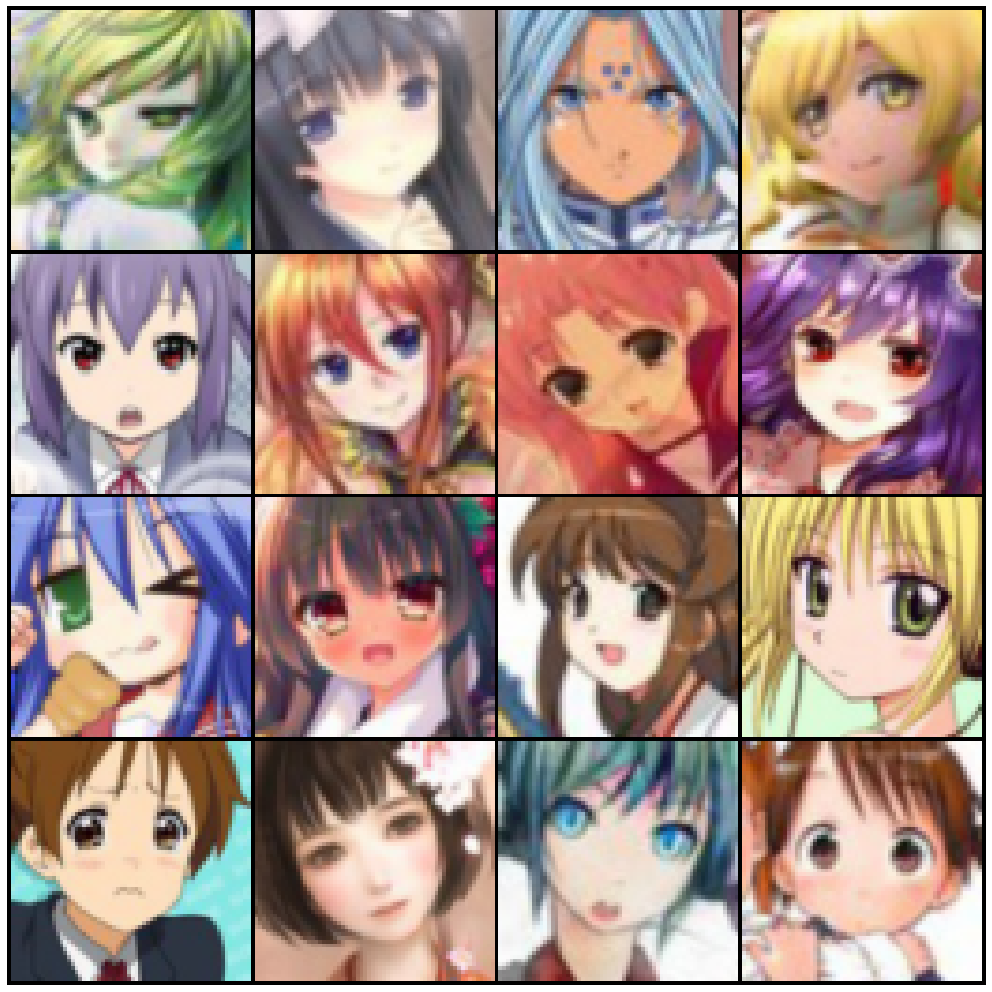

In [10]:
# 真实的图片
R = 4
fake_images = next( iter(train_loader) )[0]
images_to_show = torchvision.utils.make_grid( fake_images.detach()[: R ** 2], R, padding=1, normalize=True).cpu().permute( 1, 2, 0)
fg = plt.figure( figsize = ( 18, 18))
plt.axis('off')
plt.imshow( images_to_show)
plt.show()
print()

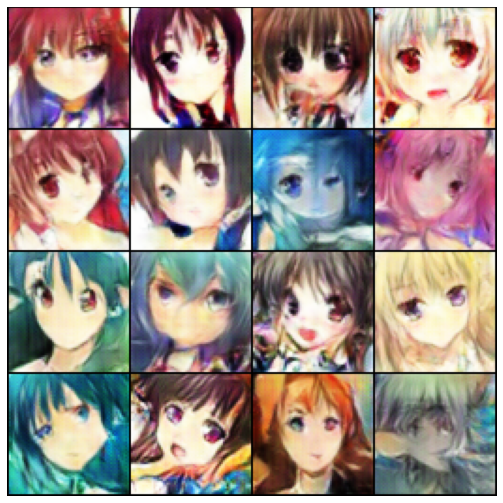

In [11]:
# 生成的图片
R = 4
G_pth = os.path.join( workspace_dir, workname, f"G_dcgan_{120}.pth")
G.load_state_dict( torch.load( G_pth))
noise = torch.randn( BATCH_SIZE, NOISE_DIM, device = device)
fake_images = G( noise)
images_to_show = torchvision.utils.make_grid( fake_images.detach()[: R ** 2], R, padding=1, normalize=True).cpu().permute( 1, 2, 0)
fg = plt.figure( figsize = ( 9, 9))
plt.axis('off')
plt.imshow( images_to_show)
plt.show()